# <center>__MÉTODOS NUMÉRICOS__</center>
## <center>__PROJETO DA UNIDADE 2__</center>

#### <center>__Equipe: Arthur Henrique Siqueira Pantaleão__</center>

<div class="alert alert-block alert-info">
1. INTRODUÇÃO
</div>

Neste projeto, aplico técnicas de Álgebra Linear Computacional em um problema clássico de **Visão Computacional**: a separação entre plano de fundo (background) e primeiro plano (foreground) em vídeos de vigilância.

O objetivo é processar uma sequência de quadros de vídeo onde a câmera está parada. Utilizando a **Decomposição de Valor Singular (SVD)**, busco isolar matematicamente o cenário estático (prédios, ruas) dos objetos em movimento (pessoas, carros), sem a necessidade de algoritmos complexos de redes neurais, baseando-me apenas na estrutura matricial dos dados.

<div class="alert alert-block alert-info">
2. DESCRIÇÃO DO PROBLEMA
</div>

O problema consiste em analisar um vídeo de câmera de segurança (CCTV). Um vídeo nada mais é do que uma sequência de imagens (quadros) ao longo do tempo.

Para o computador, organizo esses dados em uma **Matriz $M$** onde:
* Cada **coluna** da matriz representa um quadro (frame) do vídeo "achatado" (transformado em um vetor unidimensional).
* As **linhas** representam os pixels em uma posição específica ao longo do tempo.

**O Desafio:**
Se tivermos um vídeo com 100 quadros e resolução 100x100 pixels, teremos uma matriz de dimensão $10000 \times 100$. O desafio é decompor essa matriz $M$ em duas matrizes distintas:
1.  **Matriz $L$ (Low-Rank):** Que contém as informações redundantes e repetitivas (o fundo estático).
2.  **Matriz $S$ (Sparse):** Que contém as variações bruscas e raras (os objetos em movimento).

<div class="alert alert-block alert-info">
3. MÉTODOS APLICADOS À SOLUÇÃO
</div>

A ferramenta numérica central utilizada é a **SVD (Singular Value Decomposition)**.

A hipótese matemática é que o plano de fundo de um vídeo é linearmente correlacionado ao longo do tempo (pouca mudança). Logo, ele pode ser representado por uma matriz de **baixo posto (Low-Rank)**. Já o movimento é esparso e representa "ruído" ou "anomalia" em relação ao fundo.

Ao aplicar o SVD na matriz de vídeo $M$:
$$M = U \Sigma V^T$$

Podemos reconstruir uma aproximação de $M$ utilizando apenas os **$k$ maiores valores singulares** (os primeiros componentes de $\Sigma$).
* A **reconstrução** ($L$) captura os padrões mais fortes e constantes (o cenário).
* A **diferença** ($M - L$) isola o que não foi capturado pelos componentes principais, ou seja, o movimento (pessoas/carros).

<div class="alert alert-block alert-info">
4. IMPLEMENTAÇÃO
</div>

A implementação segue os passos:
1.  **Aquisição dos Dados:** Download de um vídeo de amostra de vigilância (dataset público BMC).
2.  **Pré-processamento:** Leitura do vídeo frame a frame, conversão para escala de cinza e "achatamento" dos vetores para construir a matriz $M$.
3.  **Decomposição SVD:** Aplicação do *Randomized SVD* (mais eficiente computacionalmente para matrizes grandes).
4.  **Separação:** Reconstrução do fundo usando poucos valores singulares e extração do movimento por subtração.
5.  **Visualização:** Exibição comparativa: Frame Original vs. Fundo Extraído vs. Movimento Isolado.

In [11]:
import numpy as np
import cv2 # OpenCV para manipulação de vídeo
import matplotlib.pyplot as plt
from sklearn.utils.extmath import randomized_svd
import os

In [12]:
# Carregamento do Vídeo
video_url = "https://raw.githubusercontent.com/intel-iot-devkit/sample-videos/master/person-bicycle-car-detection.mp4"
video_path = "video_teste.mp4"

if not os.path.exists(video_path):
    !wget -q -O $video_path $video_url

In [13]:
# Função para ler frames do vídeo
def carregar_video(path, max_frames=200, scale=0.5):
    cap = cv2.VideoCapture(path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret or len(frames) >= max_frames:
            break
        # Converter para escala de cinza
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # Reduzir tamanho para processamento mais rápido
        if scale != 1.0:
            gray = cv2.resize(gray, (0,0), fx=scale, fy=scale)
        frames.append(gray)
    cap.release()
    return np.array(frames)

In [14]:
# Carregar os dados
video_stack = carregar_video(video_path, max_frames=150, scale=0.4)
num_frames, height, width = video_stack.shape
print(f"Dimensões do vídeo: {num_frames} frames de tamanho {height}x{width}")

Dimensões do vídeo: 150 frames de tamanho 173x307


In [15]:
# Construção da Matriz M
# Transformar cada frame 2D em um vetor 1D (coluna)
# Matriz M terá dimensão (pixels x frames)
M = video_stack.reshape(num_frames, -1).T
print(f"Dimensão da Matriz M (Pixels x Tempo): {M.shape}")

Dimensão da Matriz M (Pixels x Tempo): (53111, 150)


In [16]:
# Aplicação do SVD
k = 2
U, Sigma, VT = randomized_svd(M, n_components=k, random_state=42)

In [17]:
# Reconstrução e Separação
# Reconstruir o Fundo (Background) -> L = U * Sigma * VT
background_matrix = U @ np.diag(Sigma) @ VT

# Obter o Primeiro Plano (Foreground) -> S = M - L
foreground_matrix = np.abs(M - background_matrix)

In [18]:
# Visualização dos Resultados
def mostrar_comparacao(frame_idx):
    # Remontar as imagens a partir das colunas das matrizes
    orig = M[:, frame_idx].reshape(height, width)
    bg = background_matrix[:, frame_idx].reshape(height, width)
    fg = foreground_matrix[:, frame_idx].reshape(height, width)

    # Plotar
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(orig, cmap='gray')
    axes[0].set_title(f"Original (Frame {frame_idx})")
    axes[0].axis('off')

    axes[1].imshow(bg, cmap='gray')
    axes[1].set_title("Fundo Extraído (Low-Rank)")
    axes[1].axis('off')

    # Aplicar um limiar no foreground para destacar melhor o movimento
    axes[2].imshow(fg, cmap='gray', vmin=0, vmax=50)
    axes[2].set_title("Movimento Isolado (Sparse)")
    axes[2].axis('off')

    plt.show()

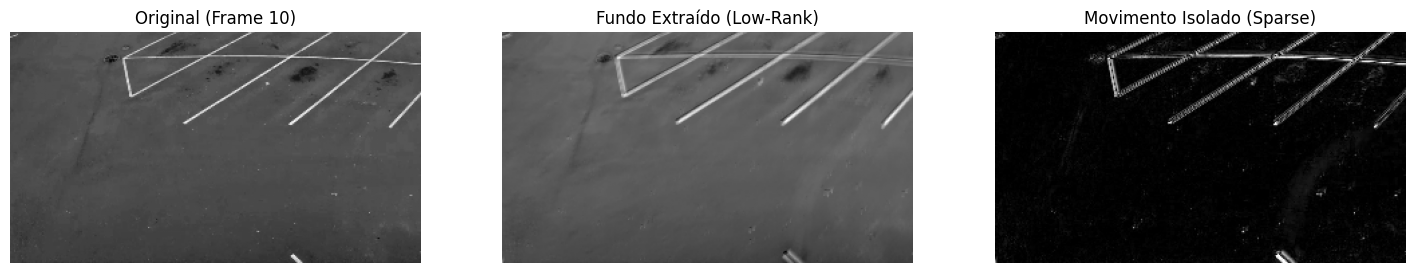

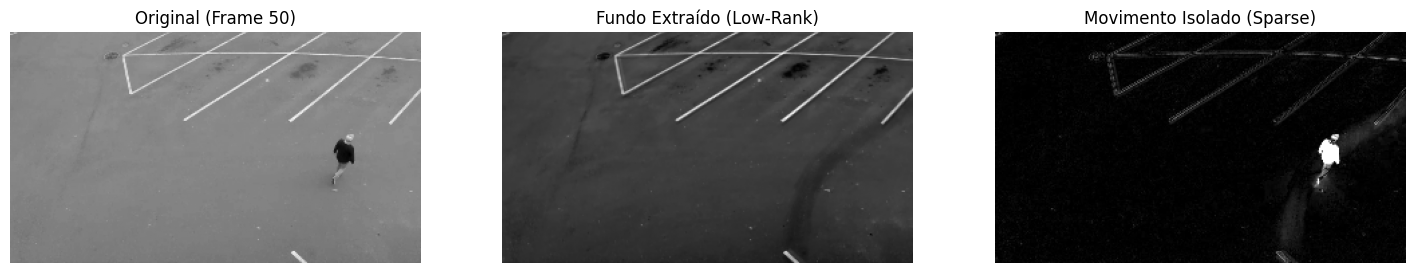

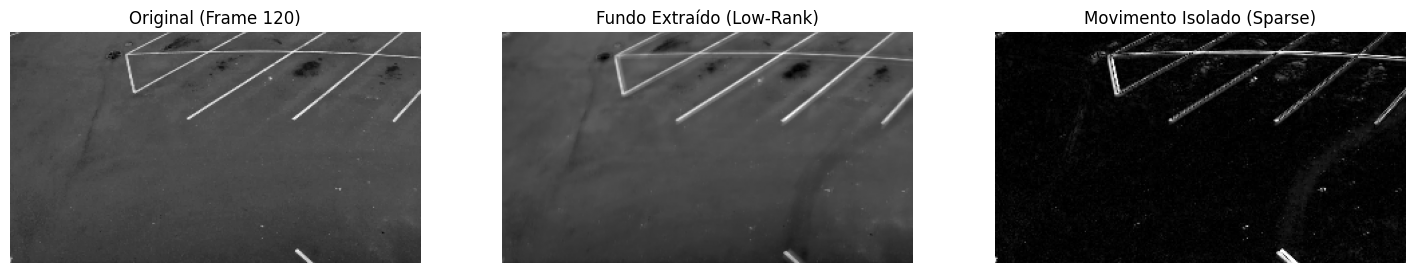

In [19]:
# Mostrar resultados para alguns frames aleatórios
mostrar_comparacao(10)  # Frame 10
mostrar_comparacao(50)  # Frame 50
mostrar_comparacao(120) # Frame 120